In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
symbol = "BTC-USD"
start="2017-06-01"
end=""

In [3]:
# "GGAL.BA" start="2014-01-01"
# "BTC-USD" start="2017-06-01"

In [4]:
import yfinance_api as yf
df = yf.getHistory(symbol,start,end)

[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-01,2288.330078,2448.389893,2288.330078,2407.879883,2407.879883,1653180032
2017-06-02,2404.030029,2488.550049,2373.320068,2488.550049,2488.550049,1317030016
2017-06-03,2493.719971,2581.909912,2423.570068,2515.350098,2515.350098,1514950016
2017-06-04,2547.790039,2585.889893,2452.540039,2511.810059,2511.810059,1355120000
2017-06-05,2512.399902,2686.810059,2510.219971,2686.810059,2686.810059,1369309952


In [6]:
data = df.filter(['Close'])


dataset = data.values

training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

1691

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00728339],
       [0.00851242],
       [0.00892073],
       ...,
       [0.58194858],
       [0.5977864 ],
       [0.57663788]])

In [8]:
train_data = scaled_data[0:int(training_data_len), :]
x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()

x_train,y_train=np.array(x_train),np.array(y_train)

x_train=np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

 


[array([0.00728339, 0.00851242, 0.00892073, 0.0088668 , 0.01153298,
       0.01422033, 0.0122239 , 0.01334308, 0.01362021, 0.01550787,
       0.01566632, 0.01111888, 0.01199324, 0.00878392, 0.00814724,
       0.00896964, 0.01106175, 0.00942258, 0.01005195, 0.01206591,
       0.01156787, 0.01181635, 0.01241815, 0.01034325, 0.01004906,
       0.00835855, 0.00948596, 0.00982632, 0.00928592, 0.00839496,
       0.00768972, 0.00878544, 0.00966284, 0.01023538, 0.01024072,
       0.01034081, 0.00897116, 0.00977376, 0.00896781, 0.00674528,
       0.00621555, 0.00714567, 0.00652193, 0.00462422, 0.00105185,
       0.        , 0.00454911, 0.00592745, 0.005235  , 0.0135256 ,
       0.01124274, 0.01341164, 0.01219708, 0.01256974, 0.00985206,
       0.00913555, 0.01130399, 0.01339473, 0.0121369 , 0.01260508])]
[0.014405290061777033]

[array([0.00728339, 0.00851242, 0.00892073, 0.0088668 , 0.01153298,
       0.01422033, 0.0122239 , 0.01334308, 0.01362021, 0.01550787,
       0.01566632, 0.01111888, 0.0

In [9]:
from keras.models import Sequential,load_model
from keras.layers import Dense,LSTM
from os.path import exists

model=""
if exists(symbol+".hdf5"):
    model=load_model(symbol+".hdf5")
else:
    model=Sequential()
    model.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(LSTM(64,return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam',loss="mean_squared_error")
    model.fit(x_train,y_train,batch_size=32,epochs=100)
    model.save(symbol+".hdf5")

In [10]:
test_data = scaled_data[training_data_len - 60: , :]

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

x_test = np.array(x_test)

x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
Predicciones=model.predict(x_test)
Predicciones=scaler.inverse_transform(Predicciones)

In [11]:
rmse=np.sqrt(np.mean(((Predicciones-y_test)**2)))
rmse

1573.61442366052

In [12]:
mape=np.mean(np.abs((y_test-Predicciones)/y_test))*100
mape

2.817205374280933

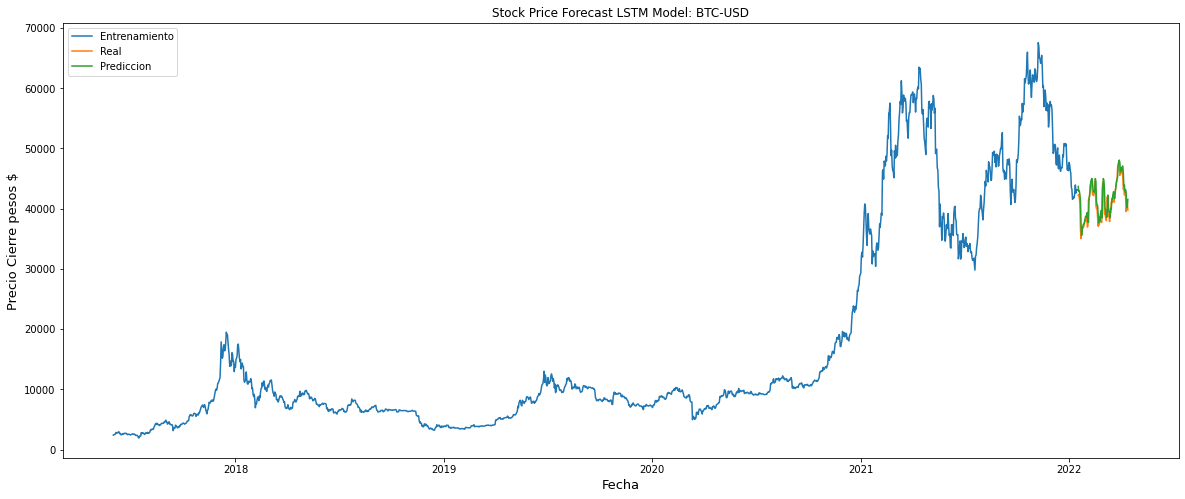

In [13]:
pd.options.mode.chained_assignment = None
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Prediccion']=Predicciones
#Visualize:
plt.figure(figsize=(20,8))
plt.title('Stock Price Forecast LSTM Model: '+symbol)
plt.xlabel('Fecha',fontsize=13)
plt.ylabel('Precio Cierre pesos $',fontsize=13)
plt.plot(train['Close'])
plt.plot(valid[['Close','Prediccion']])
plt.legend(['Entrenamiento','Real','Prediccion'], loc='upper left')
plt.show()